<a href="https://colab.research.google.com/github/pachterlab/GP_2021_2/blob/main/gg211028_dag_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bursty transcription + DAG splicing CME solutions: comparison between simulation and analytical results

In this notebook, we generate a random splicing graph, simulate it, and compare the stationary molecular distributions to the analytical results.

## Prerequisites

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import time
T_BEGIN = time.time()
%config InlineBackend.figure_format = 'retina'
_=np.seterr(divide='ignore')

In [38]:
!git clone https://github.com/pachterlab/GP_2021_2.git

fatal: destination path 'GP_2021_2' already exists and is not an empty directory.


In [39]:
cp GP_2021_2/dag_cme_burst.py .

In [40]:
# !wget -O dag_cme_burst.py https://raw.githubusercontent.com/pachterlab/GP_2021_2/main/dag_cme_burst.py

In [41]:
from dag_cme_burst import *

In [42]:
#a e s t h e t i c s
col_hist = [0.7]*3
col_theory = [1,0,0]
w_theory = 2
fontsize = 12
#a e s t h e t i c s
col_gold = [203/255,197/255,149/255]
col_gray = col_hist

fig_font_size = 18
# fig_lw = 4

## Graph construction

Initialize the graph construction algorithm with 7 species and 11 splicing reactions. The function creates a graph with a single unique root, which is the parent transcript produced at the gene locus.

In [43]:
nnod = 7
nedg = 11
seed = 1
G=random_dag(nnod,nedg,seed)
nedg = len(G.edges())

Append three degradation reactions and one transcription reaction.

In [44]:
np.random.seed(837)
n_deg = 3

In [45]:
nrxn = nedg+1+n_deg

## Simulation

Construct the stoichiometry matrix for the process.

In [46]:
S,n_deg = construct_S(nrxn,nnod,G,n_deg)

In [47]:
S

array([[-5.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  1.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  1.],
       [-1.,  0.,  0.,  0.,  0.,  1.,  0.],
       [-1.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  1.],
       [ 0.,  0.,  1.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0., -1.],
       [ 0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.]])

Generate random reaction rates.

In [48]:
k = 10**(np.random.rand(nrxn)-0.5)

In [49]:
bs = 10

In [50]:
S[0,0]=bs

In [51]:
C = construct_C(nnod,nedg,n_deg,G,k,S)
L,V,Vinv = compute_eigs(C)

Print the $C_{ij}$ matrix.

In [52]:
print(np.round(C,4))

[[-5.6384  0.      2.2076  0.      0.      1.3122  2.1186]
 [ 0.     -1.4178  0.      0.4822  0.      0.      0.    ]
 [ 0.      0.     -2.3768  0.      0.      0.      0.    ]
 [ 0.      0.      1.1588 -3.5641  2.4053  0.      0.    ]
 [ 0.      0.      0.      0.     -0.7169  0.      0.    ]
 [ 0.      0.4036  0.3745  0.      1.1941 -3.1656  1.1933]
 [ 0.      0.      0.      0.      0.5318  0.     -0.5318]]


## Analysis and comparison

Sample the system using Gillespie's stochastic simulation algorithm.

In [53]:
nCells = 1000
T = 5
measure_time = T/min(k)
tvec = np.linspace(0,measure_time,2,endpoint=True)
t_matrix = np.matlib.repmat(tvec,nCells,1)
X=gillvec(k,t_matrix,S,nCells)
X = X[:,-1,:]

Compute theoretical and empirical covariance matrix entries.

In [54]:
CV = np.zeros((nnod,nnod))
for i in range(nnod):
    for j in range(nnod):
        CV[i,j] = compute_cov(L,V,Vinv,k,bs,i,j)
cov_exp = np.cov(X.T)

Demonstrate that we are operating outside of the trivial Poisson regime: the ratio of variance to mean is higher than 1. (In simulation, this ends up being true for all but one of the species).

In [55]:
print(np.var(X.T,1)/np.mean(X.T,1))

[8.02258472 1.22       3.97315152 0.992      3.42441051 2.95451613
 5.37809427]


Plot the marginal distribution and covariance matrix entries.

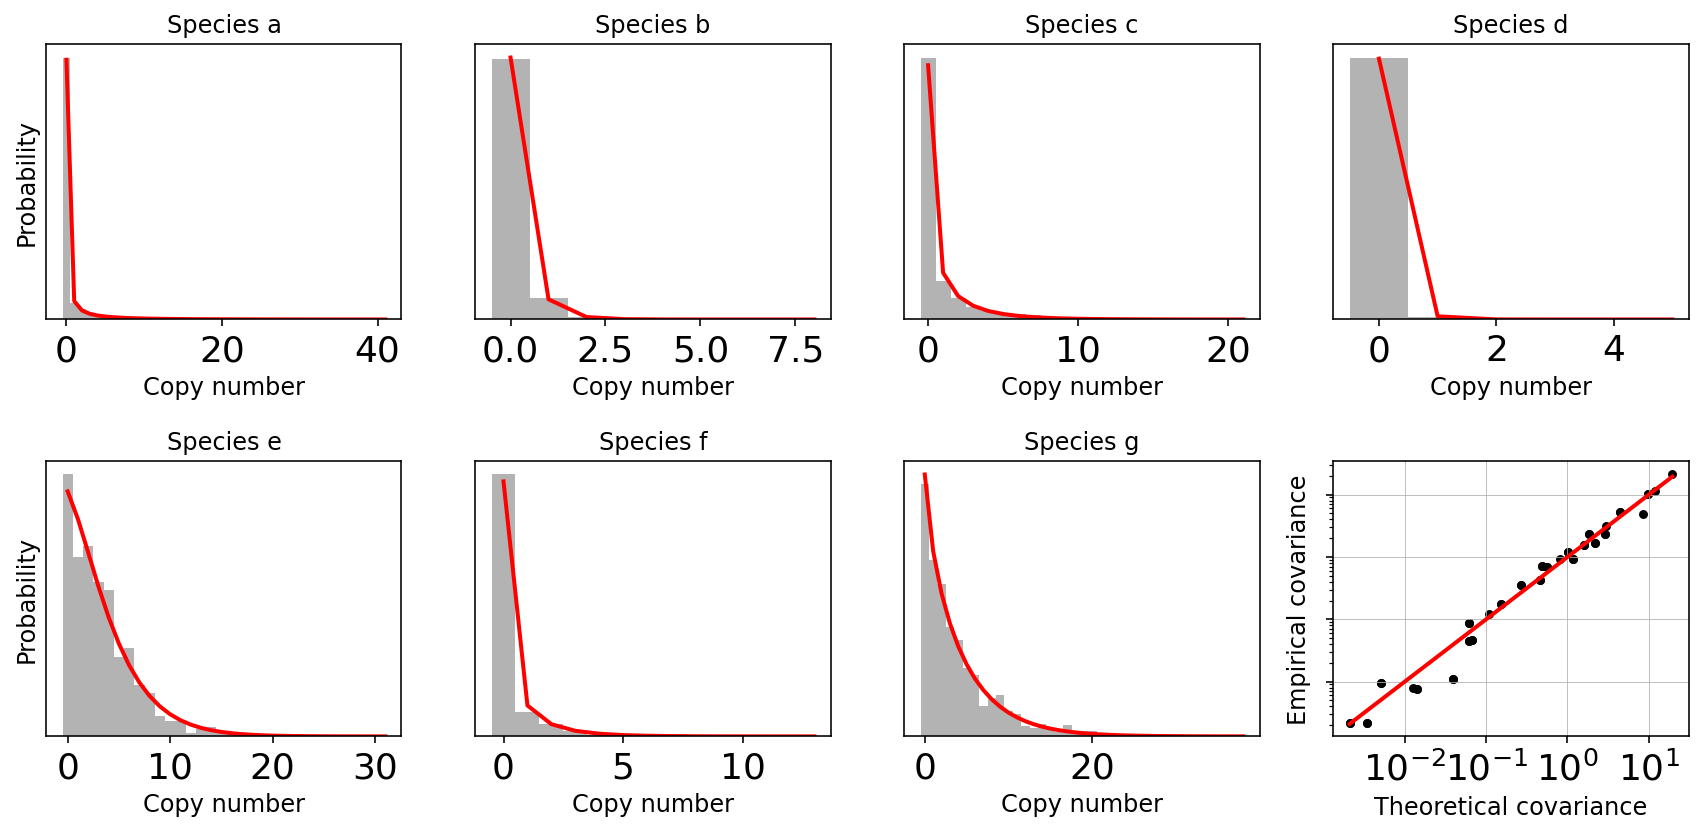

In [56]:
nr = 2
nc = 4  
fig1,ax1=plt.subplots(nrows=nr,ncols=nc,figsize=(12,6))
mx = np.amax(X,0)+5
plt.rcParams.update({'font.size': 12})

            
# for i in range(1):
for i in range(nnod):
    ax_loc = np.unravel_index(i,[nr,nc])
    x = np.arange(0,mx[i],dtype=np.int32)
    bins_ = x-0.5
    ax1[ax_loc].hist(X[:,i],bins=bins_, density=True,color=col_hist)
    bnd = np.ones(nnod,dtype=np.int32)
    bnd[i] = x[-1]+1
    P = np.squeeze(cme_integrator(L,V,Vinv,k,bnd,bs,np.inf))
    ax1[ax_loc].plot(x,P,color=col_theory, linewidth=w_theory)
    # ax1[ax_loc].set_xticks([])
    ax1[ax_loc].set_yticks([])
    ax1[ax_loc].set_xlabel('Copy number',fontsize=fontsize)
    if i==0 or i==4:
        ax1[ax_loc].set_ylabel('Probability',fontsize=fontsize)
    
    ax1[ax_loc].set_title('Species '+chr(i+97),fontsize=fontsize)

ax_loc=np.unravel_index(7,[nr,nc])
xr = [np.min(CV),np.max(CV)]
ax1[ax_loc].plot(xr,xr,color=col_theory,linewidth=w_theory)
CV = CV.flatten()
cov_exp = cov_exp.flatten()
FILT = cov_exp > 0 
ax1[ax_loc].scatter(CV[FILT],cov_exp[FILT],c='k',s=12)
ax1[ax_loc].scatter(CV[~FILT],-cov_exp[~FILT],c='m',s=12)
ax1[ax_loc].set_xscale('log')
ax1[ax_loc].set_yscale('log')

ax1[ax_loc].set_xticks([1e-2,1e-1,1,1e1])
ax1[ax_loc].set_yticks([1e-2,1e-1,1,1e1])
ax1[ax_loc].set_yticklabels([])
ax1[ax_loc].xaxis.grid(linewidth=0.4)
ax1[ax_loc].yaxis.grid(linewidth=0.4)
ax1[ax_loc].set_xlabel('Theoretical covariance',fontsize=fontsize)
ax1[ax_loc].set_ylabel('Empirical covariance',fontsize=fontsize)




fig1.tight_layout()
plt.savefig('hist_corr_fig.png',dpi=450)

Output the rates of the transcription, splicing, and degradation reactions.

In [57]:
np.round(k[0],2)

0.44

In [58]:
np.round(k[1:-3],2)

array([0.48, 2.12, 1.31, 2.21, 1.16, 2.41, 0.4 , 1.19, 0.37, 1.19, 0.53])

In [59]:
np.round(k[-3:],2)

array([0.94, 2.38, 0.72])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

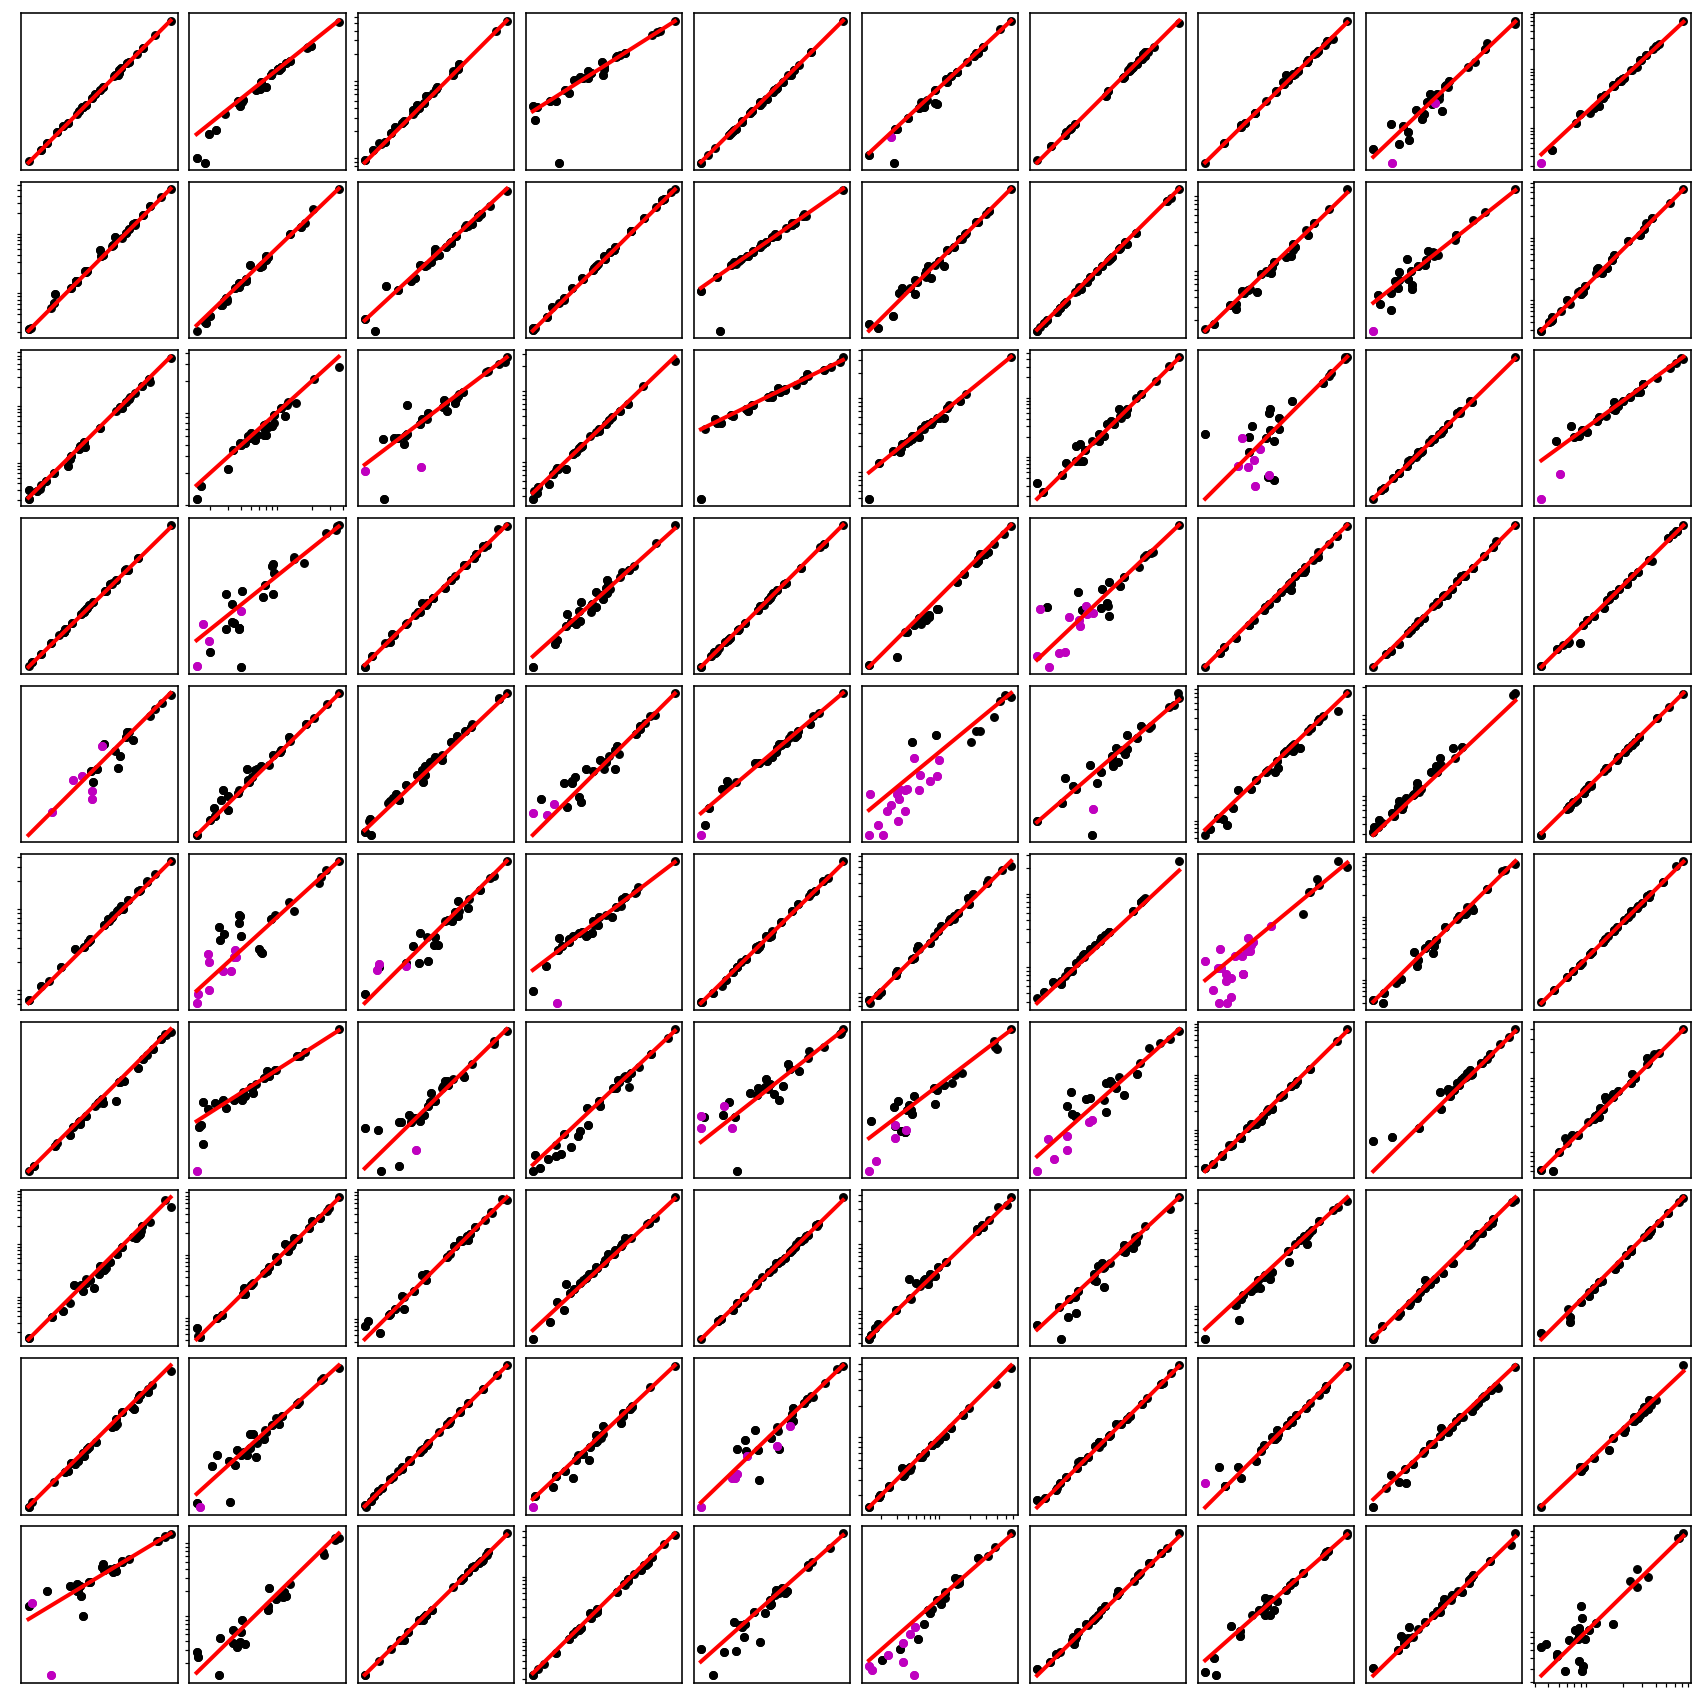

In [60]:
nr=10
nc=10
fig1,ax1=plt.subplots(nrows=nr,ncols=nc,figsize=(12,12))

t_graph = 0
t_gill = 0
t_eig = 0
t_cov = 0
t_coeff = 0
t_integral = 0
t_fft = 0
t_pmf = 0

state_space_size = []
t_pmf_state_space = []

total_state_space_size = []

for axind in range(nr*nc):
    print(axind,end=' ')
    ax_loc = np.unravel_index(axind,[nr,nc])
    

#############
    t1 = time.time()
    nnod = 7
    nedg = 11
    seed = np.random.randint(0, 1e5)
    G=random_dag(nnod,nedg,seed)
    nedg = len(G.edges())
    # print(len(np.where([G.out_degree[i]==0 for i in np.arange(nnod)])[0]),end='\n')
    n_deg = 3
    nrxn = nedg+1+n_deg
    n_deg_old=n_deg
    S,n_deg = construct_S(nrxn,nnod,G,n_deg)
    if n_deg_old != n_deg: #surprisingly, this never happens. Perhaps there's a 
                    #corresponding graph theory result that proves this analytically.
        print('updated degradation rate')
    k = 10**(np.random.rand(nrxn)-0.5)
    bs = 10**(np.clip(1+np.random.randn(),-1,2))
    S[0,0]=bs

    
    t_graph += (time.time()-t1)


    t1 = time.time()
    C = construct_C(nnod,nedg,n_deg,G,k,S)
    L,V,Vinv = compute_eigs(C)
    t_eig += (time.time()-t1)


#############
    t1 = time.time()
    nCells = 1000
    T = 5
    measure_time = T/min(k)
    tvec = np.linspace(0,measure_time,2,endpoint=True)
    t_matrix = np.matlib.repmat(tvec,nCells,1)
    X=gillvec(k,t_matrix,S,nCells)
    X = X[:,-1,:]
    t_gill += (time.time()-t1)

#############
    t1 = time.time()
    CV = np.zeros((nnod,nnod))
    for i in range(nnod):
        for j in range(nnod):
            CV[i,j] = compute_cov(L,V,Vinv,k,bs,i,j)
    t_cov += (time.time()-t1)
    cov_exp = np.cov(X.T)


# #############      
    mx = np.amax(X,0)+5 
    total_state_space_size.append(np.prod(mx))     
    for i in range(nnod):
        t1 = time.time()
        x = np.arange(0,mx[i],dtype=np.int32)
        bins_ = x-0.5
        bnd = np.ones(nnod,dtype=np.int32)
        bnd[i] = x[-1]+1
        P, t_coeff_, t_integral_, t_fft_ = cme_integrator(L,V,Vinv,k,bnd,bs,np.inf,TIME=True)

        t_pmf_ = (time.time()-t1)
        t_coeff += t_coeff_
        t_integral += t_integral_
        t_fft += t_fft_
        t_pmf += t_pmf_

        state_space_size.append(len(x))
        t_pmf_state_space.append(t_pmf_)

    xr = [np.min(CV),np.max(CV)]
    ax1[ax_loc].plot(xr,xr,color=col_theory,linewidth=w_theory)
    CV = CV.flatten()
    cov_exp = cov_exp.flatten()
    FILT = cov_exp>0
    ax1[ax_loc].scatter(CV[FILT],cov_exp[FILT],c='k',s=12)
    ax1[ax_loc].scatter(CV[~FILT],-cov_exp[~FILT],c='m',s=12)
    ax1[ax_loc].set_xscale('log')
    ax1[ax_loc].set_yscale('log')
    ax1[ax_loc].set_xticks([])
    ax1[ax_loc].set_yticks([])


fig1.tight_layout(h_pad=0.2,w_pad=0.2)
plt.savefig('cov_manysim.png',dpi=450)

Benchmark the code performance.

In [73]:
print('Graph construction time: {:.1f} ms.'.format(t_graph*1e3))
print('Simulation time:: {:.1f} ms.'.format(t_gill*1e3))
print('Spectral decomposition time: {:.1f} ms.'.format(t_eig*1e3))
print('Covariance computation time: {:.1f} ms.'.format(t_cov*1e3))
print('Coefficient computation time: {:.1f} ms.'.format(t_coeff*1e3))
print('Integral time: {:.1f} ms.'.format(t_integral*1e3))
print('IFFT time: {:.1f} ms.'.format(t_fft*1e3))
print('Total PMF computation time: {:.1f} ms.'.format(t_pmf*1e3))

Graph construction time: 607.5 ms.
Simulation time:: 848953.9 ms.
Spectral decomposition time: 89.0 ms.
Covariance computation time: 475.6 ms.
Coefficient computation time: 1037.6 ms.
Integral time: 7272.4 ms.
IFFT time: 112.7 ms.
Total PMF computation time: 8482.2 ms.


In [62]:
m,b = np.polyfit(np.log10(state_space_size),np.log10(t_pmf_state_space),1)

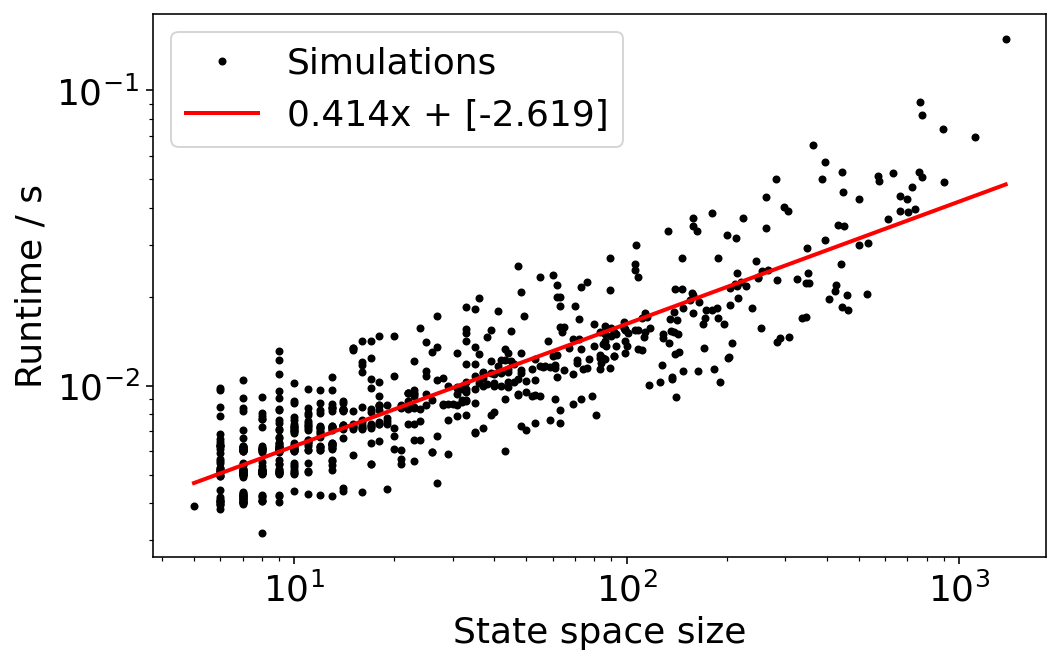

In [63]:
plt.figure(figsize=(8,5))

plt.rcParams.update({'font.size': fig_font_size})

plt.loglog(state_space_size,t_pmf_state_space,'k.',label='Simulations')
x = np.linspace(np.min(state_space_size), np.max(state_space_size))
plt.loglog(x,x**m * 10**b,'r-',linewidth=2,label='{:.3f}x + [{:.3f}]'.format(m,b))
plt.xlabel('State space size')
plt.ylabel('Runtime / s')
plt.legend(loc='upper left')


plt.savefig('time_complexity.png',dpi=450,bbox_inches='tight')


In [64]:
print(m)

0.4137487571572013


In [74]:
print(np.min(t_pmf_state_space))

0.003177642822265625


In [65]:
print(np.max(t_pmf_state_space))

0.14934396743774414


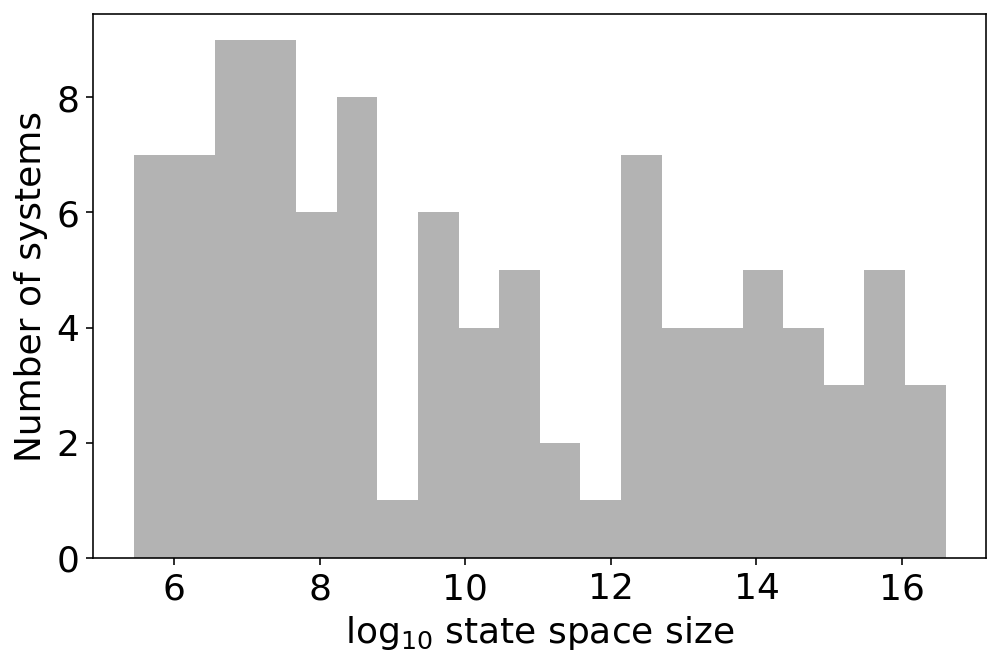

In [66]:

plt.figure(figsize=(8,5))
plt.hist(np.log10(total_state_space_size),20,color=col_gray)
plt.xlabel(r'log$_{10}$ state space size')
plt.ylabel('Number of systems')
plt.savefig('state_space_size_hist.png',dpi=450,bbox_inches='tight')


In [67]:
np.max(total_state_space_size)

39675703859542080

In [68]:
import sys

In [69]:
P.dtype

dtype('float64')

In [70]:
8*np.max(total_state_space_size)/(1024**5) #282 petabytes if we want to use FSP

281.91283163566595

In [71]:
!zip  figures.zip *.png

updating: cov_manysim.png (deflated 9%)
updating: hist_corr_fig.png (deflated 19%)
updating: state_space_size_hist.png (deflated 29%)
updating: time_complexity.png (deflated 17%)


In [72]:
print('Total runtime: {:.2f} min.'.format((time.time()-T_BEGIN)/60))

Total runtime: 14.81 min.
